# Multi-headed CNN model
see: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [1]:
# Import statements
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [2]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

# Get train and test data for each array, holding out 
X_W5 = W5_cell_data[:,1:]
y_W5 = W5_cell_data[:,0]

X_W8 = W8_cell_data[:,1:]
y_W8 = W8_cell_data[:,0]

X_W9 = W9_cell_data[:,1:]
y_W9 = W9_cell_data[:,0]

X_W10 = W10_cell_data[:,1:]
y_W10 = W10_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_W5 = np.transpose(np.reshape(X_W5, (X_W5.shape[0], 2, int(X_W5.shape[1]/2))), (0, 2, 1))
X_W8 = np.transpose(np.reshape(X_W8, (X_W8.shape[0], 2, int(X_W8.shape[1]/2))), (0, 2, 1))
X_W9 = np.transpose(np.reshape(X_W9, (X_W9.shape[0], 2, int(X_W9.shape[1]/2))), (0, 2, 1))
X_W10 = np.transpose(np.reshape(X_W10, (X_W10.shape[0], 2, int(X_W10.shape[1]/2))), (0, 2, 1))

# Split into two vectors: one for voltage, one for current; downsample to 1 seconds from 0.1 seconds
X_Volts_W5 = X_W5[:,0:-1:10,0]*10
X_Amps_W5 = X_W5[:,0:-1:10,1]
X_Volts_W8 = X_W8[:,0:-1:10,0]*10
X_Amps_W8 = X_W8[:,0:-1:10,1]
X_Volts_W9 = X_W9[:,0:-1:10,0]*10
X_Amps_W9 = X_W9[:,0:-1:10,1]
X_Volts_W10 = X_W10[:,0:-1:10,0]*10
X_Amps_W10 = X_W10[:,0:-1:10,1]

# # Split off and reserve dev set from train set
# X_Volts_W8, X_devVolts, X_Amps_W8, X_devAmps, y_W8, y_dev = train_test_split(X_Volts_W8, X_Amps_W8, y_W8, test_size=0.1, shuffle= True)

# Save dimensions for CNN
n_feat = X_W8.shape[1]


We want to train on the W8, W5, and W10 cell data, since they represent cells with different charging profiles and therefore different aging trajectories. We will use the W9 cell data as the test data.

In [6]:
X_Volts = np.vstack((X_Volts_W5, X_Volts_W8, X_Volts_W10))
X_Amps = np.vstack((X_Amps_W5, X_Amps_W8, X_Amps_W10))
y = np.hstack((y_W5, y_W8, y_W10))

# Split off and reserve dev set from train set
X_trainVolts, X_devVolts, X_trainAmps, X_devAmps, y_train, y_dev = train_test_split(X_Volts, X_Amps, y, test_size=0.1, shuffle=True)

X_testVolts = X_Volts_W9
X_testAmps = X_Amps_W9
y_test = y_W9

In [ ]:
# def getting_train_val(dataframe, interval=10):
#     x_valid = dataframe[::interval]
#     x_test = dataframe[~ dataframe(dataframe[::interval])].dropna()
#     return x_valid, x_test

In [7]:
# Rescale output to min 0, max 1:
min_max_scaler = MinMaxScaler().fit(np.concatenate((y_train, y_test, y_dev)).reshape((-1,1)))

y_train_scaled = min_max_scaler.transform(y_train.reshape((-1,1))).reshape(-1,)
y_test_scaled = min_max_scaler.transform(y_test.reshape((-1,1))).reshape(-1,)
y_dev_scaled = min_max_scaler.transform(y_dev.reshape((-1,1))).reshape(-1,)

In [26]:
# Downsample train, dev, and test by 1/100th for architecture testing
X_trainVolts_ds = X_trainVolts[0::10, :]
X_trainAmps_ds = X_trainAmps[0::10, :]
y_train_ds = y_train_scaled[0::10]

X_devVolts_ds = X_devVolts[0::10, :]
X_devAmps_ds = X_devAmps[0::10, :]
y_dev_ds = y_dev_scaled[0::10]

print(X_trainVolts_ds.shape)
print(X_trainAmps_ds.shape)
print(y_train_ds.shape)

print(X_devVolts_ds.shape)
print(X_devAmps_ds.shape)
print(y_dev_ds.shape)

X_testVolts_ds= X_testVolts[0::10, :]
X_testAmps_ds= X_testAmps[0::10, :]
y_test_ds = y_test_scaled[0::10]

print(X_testAmps_ds.shape)
print(X_testVolts_ds.shape)
print(y_test_ds.shape)

(21606, 120)
(21606, 120)
(21606,)
(2401, 120)
(2401, 120)
(2401,)
(7109, 120)
(7109, 120)
(7109,)


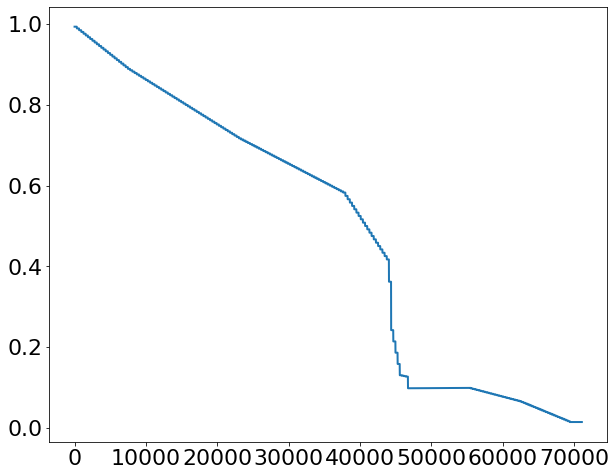

In [11]:
plt.plot(y_test_scaled)
plt.show()

[]

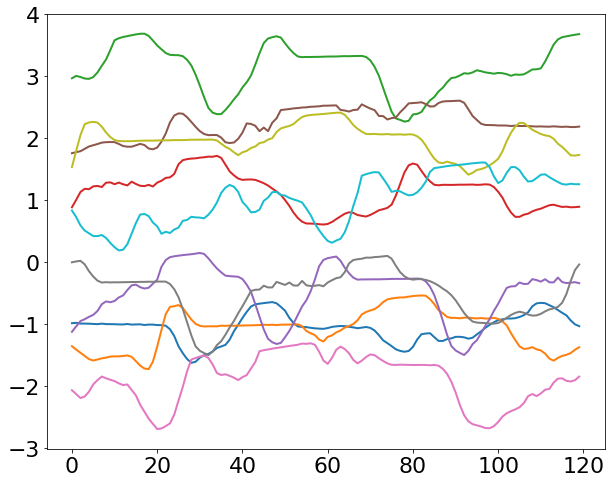

In [27]:
plt.plot(X_trainVolts_ds[100:110, :].T)
# plt.plot(X_trainAmps_ds[0:3, :].T)
plt.plot()

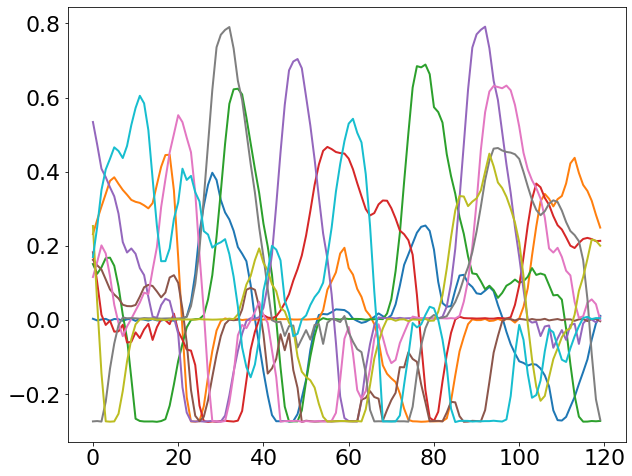

In [29]:
plt.plot(X_trainAmps_ds[100:110, :].T)
plt.show()

## Model initialization and fit

In [30]:
# 1D CNN for current and voltage data
def create_1d_cnn(feat, chan):

    inputShape = (feat, chan,)

    # define the model input
    inputs = layers.Input(shape=inputShape)
 
    x = inputs

    # the first branch operates on the first input
    x = layers.Conv1D(64, 3)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(32, 3)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(16, 3)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Conv1D(8, 5)(x)
    x = layers.MaxPool1D(pool_size=(2))(x)
    x = layers.Flatten()(x)

    model = tf.keras.models.Model(inputs, x)

    return model

In [61]:
# create the CNN models for voltage and current
cnnVolts = create_1d_cnn(120, 1)
cnnAmps = create_1d_cnn(120, 1)

# create the input to our final set of layers as the *output* of both the CNNs
combinedInput = layers.concatenate([cnnVolts.output, cnnAmps.output])

# our final FC layer head will have two dense layers, the final one
# being our regression head
# x = layers.Dense(100, activation="relu")(combinedInput)
x = layers.Dense(20, activation="relu")(combinedInput)
x = layers.Dense(1, activation="linear")(x)

model = tf.keras.models.Model(inputs=[cnnVolts.input, cnnAmps.input], outputs=x)

In [62]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 120, 1)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 120, 1)]     0           []                               
                                                                                                  
 conv1d_32 (Conv1D)             (None, 118, 64)      256         ['input_9[0][0]']                
                                                                                                  
 conv1d_36 (Conv1D)             (None, 118, 64)      256         ['input_10[0][0]']               
                                                                                           

In [63]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mean_absolute_error",
    metrics=["mean_squared_error"],
)

# history = model.fit(x=[X_trainVolts_ds, X_trainAmps_ds], y=y_train_ds,
#                     validation_data=([X_testVolts_W5_ds, X_testAmps_W5_ds], y_test_W5_ds),
#                     epochs=200,
#                     verbose=2,
#                     batch_size=92)

history = model.fit(x=[X_trainVolts, X_trainAmps], y=y_train,
                    validation_data=([X_devVolts, X_devAmps], y_dev),
                    epochs=500,
                    verbose=2,
                    batch_size=92)



Epoch 1/500


2022-05-26 23:11:30.832529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-26 23:11:53.924550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2349/2349 - 25s - loss: 0.0290 - mean_squared_error: 0.0028 - val_loss: 0.0234 - val_mean_squared_error: 7.6295e-04 - 25s/epoch - 10ms/step
Epoch 2/500
2349/2349 - 23s - loss: 0.0239 - mean_squared_error: 7.7736e-04 - val_loss: 0.0217 - val_mean_squared_error: 5.9237e-04 - 23s/epoch - 10ms/step
Epoch 3/500
2349/2349 - 24s - loss: 0.0197 - mean_squared_error: 5.7806e-04 - val_loss: 0.0157 - val_mean_squared_error: 4.3428e-04 - 24s/epoch - 10ms/step
Epoch 4/500
2349/2349 - 22s - loss: 0.0165 - mean_squared_error: 4.7611e-04 - val_loss: 0.0148 - val_mean_squared_error: 3.9124e-04 - 22s/epoch - 9ms/step
Epoch 5/500
2349/2349 - 22s - loss: 0.0154 - mean_squared_error: 4.1906e-04 - val_loss: 0.0140 - val_mean_squared_error: 3.6484e-04 - 22s/epoch - 9ms/step
Epoch 6/500
2349/2349 - 21s - loss: 0.0147 - mean_squared_error: 3.8048e-04 - val_loss: 0.0144 - val_mean_squared_error: 3.5522e-04 - 21s/epoch - 9ms/step
Epoch 7/500
2349/2349 - 22s - loss: 0.0145 - mean_squared_error: 3.5884e-04 - val_l

In [64]:
# Save completed model
model.save("mix-cnn-model_norm_MAE_500")

INFO:tensorflow:Assets written to: mix-cnn-model_norm_MAE_500/assets


INFO:tensorflow:Assets written to: mix-cnn-model_norm_MAE_500/assets


In [ ]:
%tensorboard --logdir logs

In [43]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


## Validation

In [68]:
# Load model
model = keras.models.load_model("mix-cnn-model_norm_MSE_500")
# model = keras.models.load_model("mixmodel_w8_200")

 37/223 [===>..........................] - ETA: 0s

2022-05-29 12:21:27.614639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - 1s 3ms/step


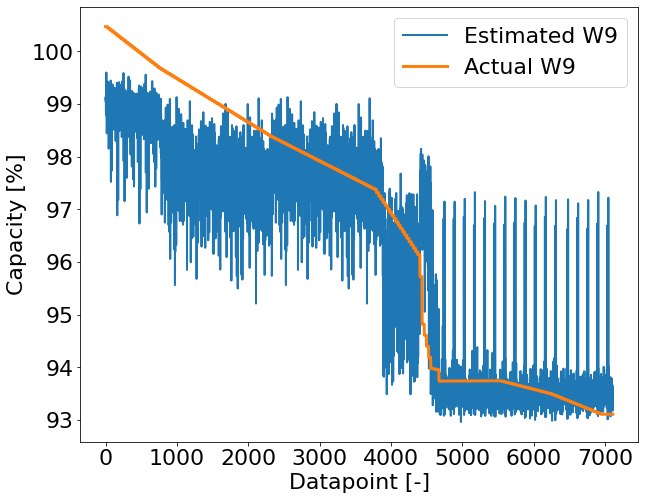

2022-05-29 12:21:28.581007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 - 1s - loss: 0.0193 - mean_squared_error: 0.0193 - 988ms/epoch - 4ms/step


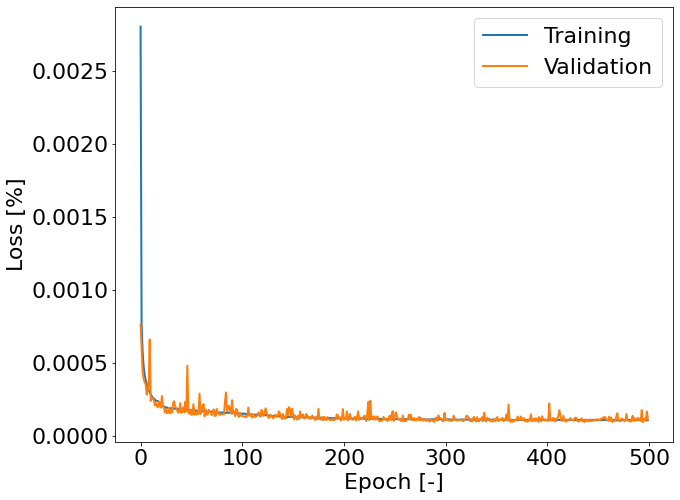

In [69]:
y_hat = model.predict([X_testVolts_ds, X_testAmps_ds])
y_hat_plot = min_max_scaler.inverse_transform(y_hat.reshape((-1,1)))
y_test_plot = min_max_scaler.inverse_transform(y_test_ds.reshape((-1,1)))
# y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot*100)
plt.plot(y_test_plot*100, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()

model.evaluate([X_testVolts_ds, X_testAmps_ds], y_test_ds, verbose=2)

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [%]")
plt.show()

In [51]:
# TODO: Try ``filtering'' -- at each cycle, average across all of the values  suggested by the model
y_hat_plot.shape

(7109, 1)

2671/2671 [==============================] - 7s 3ms/step


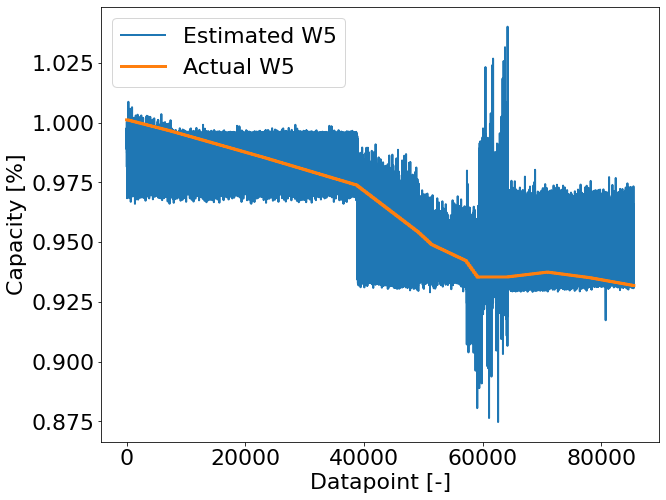

2671/2671 - 8s - loss: 0.3714 - mean_squared_error: 0.3714 - 8s/epoch - 3ms/step


[0.3714188039302826, 0.3714188039302826]

In [70]:
y_hat_W10 = model.predict([X_Volts_W5, X_Amps_W5])
y_hat_plot_W10 = min_max_scaler.inverse_transform(y_hat_W10.reshape((-1,1)))
# y_test_plot_W10 = min_max_scaler.inverse_transform(y_W5.reshape((-1,1)))
# y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
model.evaluate([X_Volts_W5, X_Amps_W5], y_W5, verbose=2)

2529/2529 [==============================] - 7s 3ms/step


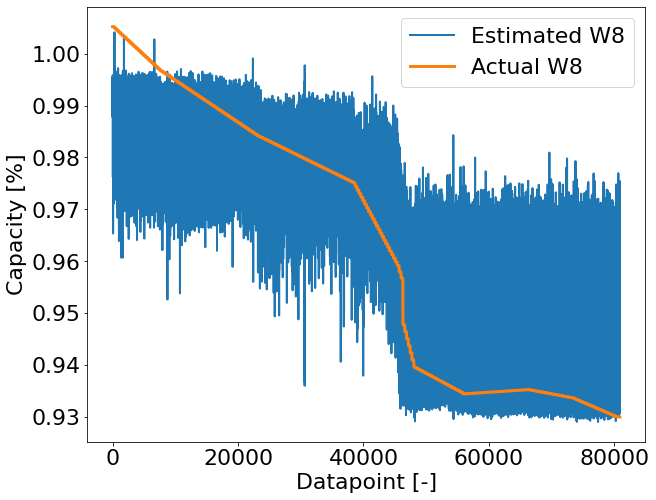

2529/2529 - 8s - loss: 0.3464 - mean_squared_error: 0.3464 - 8s/epoch - 3ms/step


[0.34644070267677307, 0.34644070267677307]

In [71]:
y_hat_W8 = model.predict([X_Volts_W8, X_Amps_W8])
y_hat_plot_W8 = min_max_scaler.inverse_transform(y_hat_W8.reshape((-1,1)))
# y_test_plot_W10 = min_max_scaler.inverse_transform(y_W5.reshape((-1,1)))
# y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W8)
plt.plot(y_W8, linewidth=3)
plt.legend(['Estimated W8', 'Actual W8'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
model.evaluate([X_Volts_W8, X_Amps_W8], y_W8, verbose=2)

2304/2304 [==============================] - 6s 3ms/step


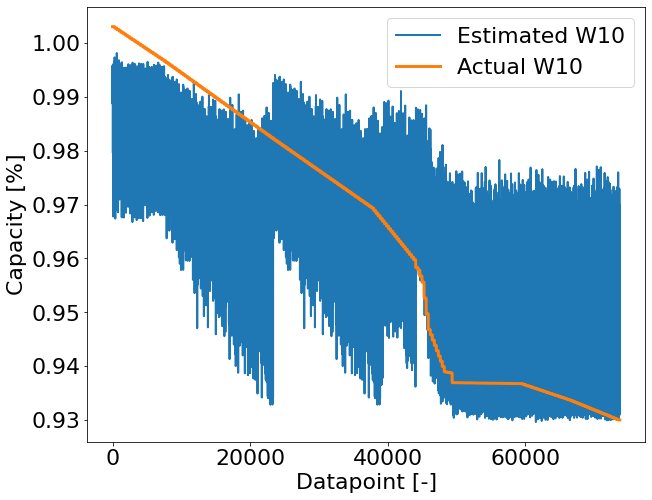

2304/2304 - 7s - loss: 0.3603 - mean_squared_error: 0.3603 - 7s/epoch - 3ms/step


[0.3602927029132843, 0.3602927029132843]

In [72]:
y_hat_W10 = model.predict([X_Volts_W10, X_Amps_W10])
y_hat_plot_W10 = min_max_scaler.inverse_transform(y_hat_W10.reshape((-1,1)))
# y_test_plot_W10 = min_max_scaler.inverse_transform(y_W5.reshape((-1,1)))
# y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
model.evaluate([X_Volts_W10, X_Amps_W10], y_W10, verbose=2)